#importing libraries

In [ ]:
import pandas as pd
import numpy as np
import xgboost
import shap
from pandas import Series,DataFrame
from google.cloud import bigquery
from pandas.io import gbq
import matplotlib.pyplot as plt

%matplotlib inline

#querying data from Google BigQuery

In [2]:
query = """select *
from `umg-uk.commercial_affairs_analytics.ML_master22_full_data` """

#reading in the data from Google BigQuery

In [3]:
df = pd.read_gbq(query, project_id='umg-uk')

Downloading: 100%|███████████████████████████████████████████████████████| 2541416/2541416 [15:54<00:00, 2661.50rows/s]


#showing all the columns, and their respective datatypes

In [5]:
df.dtypes

user_id                                                        object
total_UMG_platform_owned_playlist_streams                       int64
UMG_months_streamed                                             int64
Churn_Result                                                   object
user_country_code                                              object
user_country_name                                              object
user_age_group                                                 object
average_monthly_unique_UMG_isrc_count                           int64
average_monthly_unique_UMG_upc_count                            int64
total_umg_streams                                               int64
lean_back_streams                                               int64
lean_forward_streams                                            int64
total_playlist_streams                                          int64
total_collection_streams                                        int64
total_album_streams 

#pip install lightgbm, light gradient boosting machine

In [6]:
!pip install lightgbm

#importing lightgmb as lgbm, 
##from scikit learn importing train, test, split
###from scikit learn import confusion matrix and score resutls 

In [7]:
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

#calling all the feature columns in a list form to be used by the model, calling it feature_cols
#defining two features as categorial features, user country name and user age group
#calling X as my feature columns and y as my churn result column, 1 is churn, target slash dependent variable 
#spliting my train, test model, spliting X and y, test size is 30% of data, starting at random state 42, stratify=y meaning it will call a balanced amount 0 and 1 
#For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
#bringing in a validation between train and test 
#defining the categorial features and calling them as the variable cat

In [8]:
feature_cols = ['user_country_name',
'UMG_months_streamed',
'user_age_group',
'average_monthly_unique_UMG_isrc_count',
'average_monthly_unique_UMG_upc_count',
'average_monthly_UMG_streams',                                   
'average_monthly_UMG_owned_platform_playlist_streams',                                                   
'average_monthly_user_playlist_streams',
'percent_lean_back_streams',                
'percent_lean_forward_streams',
'percent_collection_streams',
'percent_album_streams',                                
'percent_artist_streams',
'percent_PC_streams',                                           
'percent_cellphone_streams']

df["user_country_name"] = df["user_country_name"].astype('category')
df["user_age_group"] = df["user_age_group"].astype('category')


X = df[feature_cols]
y = df.Churn_Result2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)


X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.30, random_state=42, stratify=y_train
)

cat = ["user_country_name","user_age_group"]

#creating dataset for lightgbm
#trainset, data is x_train, label is the y_train, categorial feautres was defined above, free raw data is needed so you can keep you data in a accesible form for analysis
#repeating this process for both the validation and test set

In [9]:
train_set = lgbm.Dataset(data=X_train, 
                         label=y_train,
                         categorical_feature=cat, 
                         free_raw_data=False)

validation_set = lgbm.Dataset(data=X_validation, 
                         label=y_validation,
                         categorical_feature=cat, 
                         free_raw_data=False)

test_set = lgbm.Dataset(data=X_test, 
                         label=y_test,
                         categorical_feature=cat, 
                         free_raw_data=False) 

#model parameters defined
#max depth is how deep each tree stump in going down, in this case 4 levels
#learning rate is tuning parameter for how fast a model learns
#objective is binary because I am just looking for 0 and 1s
#scale pos weight, for tuning with class weighting
#boost from average set as false, algorithm will be a slower, it adds an average to the first tree 
#feature fraction is set at 70%, ie each tree will use 70% of features


In [10]:
lgbm_params = {'max_depth': 4, 
               'learning_rate': 0.01, 
               'objective': 'binary', 
               'scale_pos_weight': y_train.value_counts()[0] / y_train.value_counts()[1] ,                    
               'boost_from_average': False,
               'feature_fraction' : 0.7,
          }

evaluation_results = {}

#use the parameters created in the above cell
#max number of trees it runs is 10000 trees
#validation set is train set and validation set
#names are train and validate for those sets
#call the results of the model, validation results
#verbose_eval is 1 means it is printing the validation results every row
#early stopping rounds means the algorithm will stop running if the validation resutls don't improve 50 trees in a row
#y pred proba is calling the model prediction X test results 
#y pred is called where the probability is over 50%, replace 1 if it is untrue replace with a 0

In [11]:
model = lgbm.train(train_set = train_set, 
                   params = lgbm_params,
                   num_boost_round = 10000,
                   valid_sets = [train_set, validation_set],
                   valid_names = ['Train', 'Validate'], 
                   evals_result = evaluation_results,
                   verbose_eval = 1,
                   early_stopping_rounds=50,
                   )

y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
# saving model
# dump(model, 'model_lgbm.joblib')  
# dump(evaluation_results, 'evaluation_results_lgbm.joblib')

C:\Users\EricksS\Anaconda4\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	Train's binary_logloss: 0.69117	Validate's binary_logloss: 0.691167
Training until validation scores don't improve for 50 rounds
[2]	Train's binary_logloss: 0.689222	Validate's binary_logloss: 0.689218
[3]	Train's binary_logloss: 0.686303	Validate's binary_logloss: 0.686297
[4]	Train's binary_logloss: 0.683439	Validate's binary_logloss: 0.683432
[5]	Train's binary_logloss: 0.681598	Validate's binary_logloss: 0.681589
[6]	Train's binary_logloss: 0.679792	Validate's binary_logloss: 0.679781
[7]	Train's binary_logloss: 0.677047	Validate's binary_logloss: 0.677034
[8]	Train's binary_logloss: 0.674376	Validate's binary_logloss: 0.674362
[9]	Train's binary_logloss: 0.671755	Validate's binary_logloss: 0.671742
[10]	Train's binary_logloss: 0.670308	Validate's binary_logloss: 0.670298
[11]	Train's binary_logloss: 0.667735	Validate's binary_logloss: 0.667724
[12]	Train's binary_logloss: 0.66521	Validate's binary_logloss: 0.665197
[13]	Train's binary_logloss: 0.663611	Validate's binary_loglos

[112]	Train's binary_logloss: 0.548738	Validate's binary_logloss: 0.548636
[113]	Train's binary_logloss: 0.548162	Validate's binary_logloss: 0.548059
[114]	Train's binary_logloss: 0.547812	Validate's binary_logloss: 0.547706
[115]	Train's binary_logloss: 0.547256	Validate's binary_logloss: 0.54715
[116]	Train's binary_logloss: 0.546913	Validate's binary_logloss: 0.546805
[117]	Train's binary_logloss: 0.546594	Validate's binary_logloss: 0.546484
[118]	Train's binary_logloss: 0.54605	Validate's binary_logloss: 0.54594
[119]	Train's binary_logloss: 0.545514	Validate's binary_logloss: 0.545406
[120]	Train's binary_logloss: 0.545195	Validate's binary_logloss: 0.545083
[121]	Train's binary_logloss: 0.544665	Validate's binary_logloss: 0.544553
[122]	Train's binary_logloss: 0.544353	Validate's binary_logloss: 0.544239
[123]	Train's binary_logloss: 0.543839	Validate's binary_logloss: 0.543725
[124]	Train's binary_logloss: 0.54334	Validate's binary_logloss: 0.543225
[125]	Train's binary_logloss:

[222]	Train's binary_logloss: 0.517829	Validate's binary_logloss: 0.517661
[223]	Train's binary_logloss: 0.517681	Validate's binary_logloss: 0.517514
[224]	Train's binary_logloss: 0.517589	Validate's binary_logloss: 0.517421
[225]	Train's binary_logloss: 0.517444	Validate's binary_logloss: 0.517276
[226]	Train's binary_logloss: 0.517303	Validate's binary_logloss: 0.517135
[227]	Train's binary_logloss: 0.517216	Validate's binary_logloss: 0.517048
[228]	Train's binary_logloss: 0.51707	Validate's binary_logloss: 0.516902
[229]	Train's binary_logloss: 0.516929	Validate's binary_logloss: 0.516761
[230]	Train's binary_logloss: 0.516844	Validate's binary_logloss: 0.516676
[231]	Train's binary_logloss: 0.516707	Validate's binary_logloss: 0.516539
[232]	Train's binary_logloss: 0.516574	Validate's binary_logloss: 0.516405
[233]	Train's binary_logloss: 0.51644	Validate's binary_logloss: 0.516271
[234]	Train's binary_logloss: 0.516359	Validate's binary_logloss: 0.51619
[235]	Train's binary_logloss

[332]	Train's binary_logloss: 0.509118	Validate's binary_logloss: 0.508984
[333]	Train's binary_logloss: 0.509073	Validate's binary_logloss: 0.508939
[334]	Train's binary_logloss: 0.509019	Validate's binary_logloss: 0.508887
[335]	Train's binary_logloss: 0.508974	Validate's binary_logloss: 0.508841
[336]	Train's binary_logloss: 0.508928	Validate's binary_logloss: 0.508796
[337]	Train's binary_logloss: 0.508894	Validate's binary_logloss: 0.508761
[338]	Train's binary_logloss: 0.508843	Validate's binary_logloss: 0.508711
[339]	Train's binary_logloss: 0.5088	Validate's binary_logloss: 0.508667
[340]	Train's binary_logloss: 0.508753	Validate's binary_logloss: 0.50862
[341]	Train's binary_logloss: 0.508711	Validate's binary_logloss: 0.508579
[342]	Train's binary_logloss: 0.508663	Validate's binary_logloss: 0.508532
[343]	Train's binary_logloss: 0.508613	Validate's binary_logloss: 0.508484
[344]	Train's binary_logloss: 0.508557	Validate's binary_logloss: 0.508429
[345]	Train's binary_logloss

[442]	Train's binary_logloss: 0.505721	Validate's binary_logloss: 0.505647
[443]	Train's binary_logloss: 0.505699	Validate's binary_logloss: 0.505625
[444]	Train's binary_logloss: 0.50568	Validate's binary_logloss: 0.505607
[445]	Train's binary_logloss: 0.50566	Validate's binary_logloss: 0.505587
[446]	Train's binary_logloss: 0.505636	Validate's binary_logloss: 0.505564
[447]	Train's binary_logloss: 0.505619	Validate's binary_logloss: 0.505547
[448]	Train's binary_logloss: 0.5056	Validate's binary_logloss: 0.505529
[449]	Train's binary_logloss: 0.505583	Validate's binary_logloss: 0.505512
[450]	Train's binary_logloss: 0.505565	Validate's binary_logloss: 0.505495
[451]	Train's binary_logloss: 0.505544	Validate's binary_logloss: 0.505475
[452]	Train's binary_logloss: 0.505528	Validate's binary_logloss: 0.50546
[453]	Train's binary_logloss: 0.50551	Validate's binary_logloss: 0.505443
[454]	Train's binary_logloss: 0.505494	Validate's binary_logloss: 0.505427
[455]	Train's binary_logloss: 0

[552]	Train's binary_logloss: 0.504039	Validate's binary_logloss: 0.504042
[553]	Train's binary_logloss: 0.504025	Validate's binary_logloss: 0.504029
[554]	Train's binary_logloss: 0.504017	Validate's binary_logloss: 0.504021
[555]	Train's binary_logloss: 0.504007	Validate's binary_logloss: 0.504011
[556]	Train's binary_logloss: 0.503996	Validate's binary_logloss: 0.504
[557]	Train's binary_logloss: 0.503988	Validate's binary_logloss: 0.503993
[558]	Train's binary_logloss: 0.503977	Validate's binary_logloss: 0.503983
[559]	Train's binary_logloss: 0.503969	Validate's binary_logloss: 0.503976
[560]	Train's binary_logloss: 0.503961	Validate's binary_logloss: 0.503968
[561]	Train's binary_logloss: 0.503953	Validate's binary_logloss: 0.503961
[562]	Train's binary_logloss: 0.503935	Validate's binary_logloss: 0.503945
[563]	Train's binary_logloss: 0.503927	Validate's binary_logloss: 0.503937
[564]	Train's binary_logloss: 0.503917	Validate's binary_logloss: 0.503929
[565]	Train's binary_logloss

[662]	Train's binary_logloss: 0.503061	Validate's binary_logloss: 0.503144
[663]	Train's binary_logloss: 0.503057	Validate's binary_logloss: 0.503141
[664]	Train's binary_logloss: 0.50305	Validate's binary_logloss: 0.503133
[665]	Train's binary_logloss: 0.503045	Validate's binary_logloss: 0.503129
[666]	Train's binary_logloss: 0.503038	Validate's binary_logloss: 0.503123
[667]	Train's binary_logloss: 0.503034	Validate's binary_logloss: 0.50312
[668]	Train's binary_logloss: 0.503021	Validate's binary_logloss: 0.503108
[669]	Train's binary_logloss: 0.503014	Validate's binary_logloss: 0.503101
[670]	Train's binary_logloss: 0.503007	Validate's binary_logloss: 0.503096
[671]	Train's binary_logloss: 0.503	Validate's binary_logloss: 0.50309
[672]	Train's binary_logloss: 0.502985	Validate's binary_logloss: 0.503076
[673]	Train's binary_logloss: 0.502979	Validate's binary_logloss: 0.503071
[674]	Train's binary_logloss: 0.502973	Validate's binary_logloss: 0.503064
[675]	Train's binary_logloss: 0

[772]	Train's binary_logloss: 0.5024	Validate's binary_logloss: 0.502575
[773]	Train's binary_logloss: 0.502394	Validate's binary_logloss: 0.502569
[774]	Train's binary_logloss: 0.502392	Validate's binary_logloss: 0.502567
[775]	Train's binary_logloss: 0.502387	Validate's binary_logloss: 0.502563
[776]	Train's binary_logloss: 0.502378	Validate's binary_logloss: 0.502555
[777]	Train's binary_logloss: 0.502375	Validate's binary_logloss: 0.502554
[778]	Train's binary_logloss: 0.502372	Validate's binary_logloss: 0.502551
[779]	Train's binary_logloss: 0.502363	Validate's binary_logloss: 0.502543
[780]	Train's binary_logloss: 0.502361	Validate's binary_logloss: 0.502541
[781]	Train's binary_logloss: 0.502357	Validate's binary_logloss: 0.502538
[782]	Train's binary_logloss: 0.502353	Validate's binary_logloss: 0.502535
[783]	Train's binary_logloss: 0.502347	Validate's binary_logloss: 0.50253
[784]	Train's binary_logloss: 0.502343	Validate's binary_logloss: 0.502527
[785]	Train's binary_logloss

[883]	Train's binary_logloss: 0.501879	Validate's binary_logloss: 0.502137
[884]	Train's binary_logloss: 0.501877	Validate's binary_logloss: 0.502135
[885]	Train's binary_logloss: 0.501872	Validate's binary_logloss: 0.502132
[886]	Train's binary_logloss: 0.501868	Validate's binary_logloss: 0.502128
[887]	Train's binary_logloss: 0.501863	Validate's binary_logloss: 0.502124
[888]	Train's binary_logloss: 0.501858	Validate's binary_logloss: 0.50212
[889]	Train's binary_logloss: 0.501853	Validate's binary_logloss: 0.502116
[890]	Train's binary_logloss: 0.501847	Validate's binary_logloss: 0.502111
[891]	Train's binary_logloss: 0.501844	Validate's binary_logloss: 0.502109
[892]	Train's binary_logloss: 0.501841	Validate's binary_logloss: 0.502106
[893]	Train's binary_logloss: 0.501837	Validate's binary_logloss: 0.502104
[894]	Train's binary_logloss: 0.501833	Validate's binary_logloss: 0.502101
[895]	Train's binary_logloss: 0.501829	Validate's binary_logloss: 0.502097
[896]	Train's binary_loglo

[993]	Train's binary_logloss: 0.501406	Validate's binary_logloss: 0.501753
[994]	Train's binary_logloss: 0.501402	Validate's binary_logloss: 0.50175
[995]	Train's binary_logloss: 0.5014	Validate's binary_logloss: 0.501748
[996]	Train's binary_logloss: 0.501398	Validate's binary_logloss: 0.501747
[997]	Train's binary_logloss: 0.501395	Validate's binary_logloss: 0.501745
[998]	Train's binary_logloss: 0.50139	Validate's binary_logloss: 0.50174
[999]	Train's binary_logloss: 0.501385	Validate's binary_logloss: 0.501736
[1000]	Train's binary_logloss: 0.50138	Validate's binary_logloss: 0.501732
[1001]	Train's binary_logloss: 0.501377	Validate's binary_logloss: 0.50173
[1002]	Train's binary_logloss: 0.501375	Validate's binary_logloss: 0.501729
[1003]	Train's binary_logloss: 0.501371	Validate's binary_logloss: 0.501727
[1004]	Train's binary_logloss: 0.501365	Validate's binary_logloss: 0.501721
[1005]	Train's binary_logloss: 0.501362	Validate's binary_logloss: 0.501719
[1006]	Train's binary_logl

[1102]	Train's binary_logloss: 0.501022	Validate's binary_logloss: 0.501452
[1103]	Train's binary_logloss: 0.501019	Validate's binary_logloss: 0.50145
[1104]	Train's binary_logloss: 0.501015	Validate's binary_logloss: 0.501446
[1105]	Train's binary_logloss: 0.501007	Validate's binary_logloss: 0.501438
[1106]	Train's binary_logloss: 0.501004	Validate's binary_logloss: 0.501436
[1107]	Train's binary_logloss: 0.500999	Validate's binary_logloss: 0.501432
[1108]	Train's binary_logloss: 0.500992	Validate's binary_logloss: 0.501425
[1109]	Train's binary_logloss: 0.500989	Validate's binary_logloss: 0.501424
[1110]	Train's binary_logloss: 0.500985	Validate's binary_logloss: 0.50142
[1111]	Train's binary_logloss: 0.50098	Validate's binary_logloss: 0.501415
[1112]	Train's binary_logloss: 0.500977	Validate's binary_logloss: 0.501413
[1113]	Train's binary_logloss: 0.500965	Validate's binary_logloss: 0.501402
[1114]	Train's binary_logloss: 0.500961	Validate's binary_logloss: 0.501398
[1115]	Train's 

[1211]	Train's binary_logloss: 0.50065	Validate's binary_logloss: 0.501154
[1212]	Train's binary_logloss: 0.500645	Validate's binary_logloss: 0.501151
[1213]	Train's binary_logloss: 0.500636	Validate's binary_logloss: 0.501141
[1214]	Train's binary_logloss: 0.500634	Validate's binary_logloss: 0.501139
[1215]	Train's binary_logloss: 0.500632	Validate's binary_logloss: 0.501138
[1216]	Train's binary_logloss: 0.500628	Validate's binary_logloss: 0.501135
[1217]	Train's binary_logloss: 0.500619	Validate's binary_logloss: 0.501127
[1218]	Train's binary_logloss: 0.500617	Validate's binary_logloss: 0.501125
[1219]	Train's binary_logloss: 0.500615	Validate's binary_logloss: 0.501124
[1220]	Train's binary_logloss: 0.500613	Validate's binary_logloss: 0.501123
[1221]	Train's binary_logloss: 0.500612	Validate's binary_logloss: 0.501122
[1222]	Train's binary_logloss: 0.500608	Validate's binary_logloss: 0.50112
[1223]	Train's binary_logloss: 0.500607	Validate's binary_logloss: 0.501119
[1224]	Train's

[1320]	Train's binary_logloss: 0.500329	Validate's binary_logloss: 0.50091
[1321]	Train's binary_logloss: 0.500322	Validate's binary_logloss: 0.500904
[1322]	Train's binary_logloss: 0.500318	Validate's binary_logloss: 0.5009
[1323]	Train's binary_logloss: 0.500316	Validate's binary_logloss: 0.5009
[1324]	Train's binary_logloss: 0.500313	Validate's binary_logloss: 0.500898
[1325]	Train's binary_logloss: 0.500311	Validate's binary_logloss: 0.500897
[1326]	Train's binary_logloss: 0.50031	Validate's binary_logloss: 0.500896
[1327]	Train's binary_logloss: 0.500304	Validate's binary_logloss: 0.500891
[1328]	Train's binary_logloss: 0.500301	Validate's binary_logloss: 0.500889
[1329]	Train's binary_logloss: 0.5003	Validate's binary_logloss: 0.500889
[1330]	Train's binary_logloss: 0.500298	Validate's binary_logloss: 0.500888
[1331]	Train's binary_logloss: 0.500296	Validate's binary_logloss: 0.500887
[1332]	Train's binary_logloss: 0.500294	Validate's binary_logloss: 0.500886
[1333]	Train's binar

[1429]	Train's binary_logloss: 0.500047	Validate's binary_logloss: 0.500708
[1430]	Train's binary_logloss: 0.500045	Validate's binary_logloss: 0.500707
[1431]	Train's binary_logloss: 0.500044	Validate's binary_logloss: 0.500706
[1432]	Train's binary_logloss: 0.500043	Validate's binary_logloss: 0.500705
[1433]	Train's binary_logloss: 0.50004	Validate's binary_logloss: 0.500703
[1434]	Train's binary_logloss: 0.500037	Validate's binary_logloss: 0.500701
[1435]	Train's binary_logloss: 0.500034	Validate's binary_logloss: 0.500699
[1436]	Train's binary_logloss: 0.50003	Validate's binary_logloss: 0.500696
[1437]	Train's binary_logloss: 0.500028	Validate's binary_logloss: 0.500695
[1438]	Train's binary_logloss: 0.500026	Validate's binary_logloss: 0.500693
[1439]	Train's binary_logloss: 0.500025	Validate's binary_logloss: 0.500693
[1440]	Train's binary_logloss: 0.500021	Validate's binary_logloss: 0.50069
[1441]	Train's binary_logloss: 0.500019	Validate's binary_logloss: 0.500689
[1442]	Train's 

[1538]	Train's binary_logloss: 0.499784	Validate's binary_logloss: 0.500521
[1539]	Train's binary_logloss: 0.499783	Validate's binary_logloss: 0.50052
[1540]	Train's binary_logloss: 0.499782	Validate's binary_logloss: 0.500519
[1541]	Train's binary_logloss: 0.499781	Validate's binary_logloss: 0.500519
[1542]	Train's binary_logloss: 0.499779	Validate's binary_logloss: 0.500518
[1543]	Train's binary_logloss: 0.499777	Validate's binary_logloss: 0.500517
[1544]	Train's binary_logloss: 0.499776	Validate's binary_logloss: 0.500517
[1545]	Train's binary_logloss: 0.499775	Validate's binary_logloss: 0.500516
[1546]	Train's binary_logloss: 0.499773	Validate's binary_logloss: 0.500515
[1547]	Train's binary_logloss: 0.499771	Validate's binary_logloss: 0.500514
[1548]	Train's binary_logloss: 0.499769	Validate's binary_logloss: 0.500512
[1549]	Train's binary_logloss: 0.499767	Validate's binary_logloss: 0.50051
[1550]	Train's binary_logloss: 0.499764	Validate's binary_logloss: 0.500508
[1551]	Train's

[1647]	Train's binary_logloss: 0.49957	Validate's binary_logloss: 0.500392
[1648]	Train's binary_logloss: 0.499569	Validate's binary_logloss: 0.500391
[1649]	Train's binary_logloss: 0.499568	Validate's binary_logloss: 0.500391
[1650]	Train's binary_logloss: 0.499567	Validate's binary_logloss: 0.50039
[1651]	Train's binary_logloss: 0.499565	Validate's binary_logloss: 0.500389
[1652]	Train's binary_logloss: 0.499564	Validate's binary_logloss: 0.500388
[1653]	Train's binary_logloss: 0.49956	Validate's binary_logloss: 0.500385
[1654]	Train's binary_logloss: 0.499558	Validate's binary_logloss: 0.500384
[1655]	Train's binary_logloss: 0.499557	Validate's binary_logloss: 0.500383
[1656]	Train's binary_logloss: 0.499556	Validate's binary_logloss: 0.500382
[1657]	Train's binary_logloss: 0.499554	Validate's binary_logloss: 0.500382
[1658]	Train's binary_logloss: 0.499553	Validate's binary_logloss: 0.500381
[1659]	Train's binary_logloss: 0.499552	Validate's binary_logloss: 0.500381
[1660]	Train's 

[1756]	Train's binary_logloss: 0.499369	Validate's binary_logloss: 0.500271
[1757]	Train's binary_logloss: 0.499368	Validate's binary_logloss: 0.500271
[1758]	Train's binary_logloss: 0.499367	Validate's binary_logloss: 0.500271
[1759]	Train's binary_logloss: 0.499364	Validate's binary_logloss: 0.500269
[1760]	Train's binary_logloss: 0.499363	Validate's binary_logloss: 0.500269
[1761]	Train's binary_logloss: 0.499362	Validate's binary_logloss: 0.500268
[1762]	Train's binary_logloss: 0.499361	Validate's binary_logloss: 0.500267
[1763]	Train's binary_logloss: 0.49936	Validate's binary_logloss: 0.500267
[1764]	Train's binary_logloss: 0.499358	Validate's binary_logloss: 0.500267
[1765]	Train's binary_logloss: 0.499357	Validate's binary_logloss: 0.500267
[1766]	Train's binary_logloss: 0.499356	Validate's binary_logloss: 0.500266
[1767]	Train's binary_logloss: 0.499355	Validate's binary_logloss: 0.500265
[1768]	Train's binary_logloss: 0.499354	Validate's binary_logloss: 0.500265
[1769]	Train'

[1865]	Train's binary_logloss: 0.499183	Validate's binary_logloss: 0.500165
[1866]	Train's binary_logloss: 0.499182	Validate's binary_logloss: 0.500165
[1867]	Train's binary_logloss: 0.499181	Validate's binary_logloss: 0.500165
[1868]	Train's binary_logloss: 0.49918	Validate's binary_logloss: 0.500164
[1869]	Train's binary_logloss: 0.499177	Validate's binary_logloss: 0.500162
[1870]	Train's binary_logloss: 0.499176	Validate's binary_logloss: 0.500161
[1871]	Train's binary_logloss: 0.499175	Validate's binary_logloss: 0.500161
[1872]	Train's binary_logloss: 0.499174	Validate's binary_logloss: 0.500161
[1873]	Train's binary_logloss: 0.499172	Validate's binary_logloss: 0.50016
[1874]	Train's binary_logloss: 0.499171	Validate's binary_logloss: 0.500159
[1875]	Train's binary_logloss: 0.49917	Validate's binary_logloss: 0.500159
[1876]	Train's binary_logloss: 0.499169	Validate's binary_logloss: 0.500159
[1877]	Train's binary_logloss: 0.499167	Validate's binary_logloss: 0.500158
[1878]	Train's 

[1974]	Train's binary_logloss: 0.499028	Validate's binary_logloss: 0.500093
[1975]	Train's binary_logloss: 0.499027	Validate's binary_logloss: 0.500093
[1976]	Train's binary_logloss: 0.499025	Validate's binary_logloss: 0.500091
[1977]	Train's binary_logloss: 0.499024	Validate's binary_logloss: 0.50009
[1978]	Train's binary_logloss: 0.499021	Validate's binary_logloss: 0.500088
[1979]	Train's binary_logloss: 0.499019	Validate's binary_logloss: 0.500087
[1980]	Train's binary_logloss: 0.499018	Validate's binary_logloss: 0.500087
[1981]	Train's binary_logloss: 0.499017	Validate's binary_logloss: 0.500087
[1982]	Train's binary_logloss: 0.499014	Validate's binary_logloss: 0.500085
[1983]	Train's binary_logloss: 0.499013	Validate's binary_logloss: 0.500085
[1984]	Train's binary_logloss: 0.499013	Validate's binary_logloss: 0.500085
[1985]	Train's binary_logloss: 0.499011	Validate's binary_logloss: 0.500083
[1986]	Train's binary_logloss: 0.499009	Validate's binary_logloss: 0.500082
[1987]	Train'

[2083]	Train's binary_logloss: 0.498862	Validate's binary_logloss: 0.500006
[2084]	Train's binary_logloss: 0.49886	Validate's binary_logloss: 0.500004
[2085]	Train's binary_logloss: 0.498859	Validate's binary_logloss: 0.500004
[2086]	Train's binary_logloss: 0.498858	Validate's binary_logloss: 0.500004
[2087]	Train's binary_logloss: 0.498857	Validate's binary_logloss: 0.500003
[2088]	Train's binary_logloss: 0.498854	Validate's binary_logloss: 0.500001
[2089]	Train's binary_logloss: 0.498853	Validate's binary_logloss: 0.500001
[2090]	Train's binary_logloss: 0.498851	Validate's binary_logloss: 0.499999
[2091]	Train's binary_logloss: 0.49885	Validate's binary_logloss: 0.499999
[2092]	Train's binary_logloss: 0.498849	Validate's binary_logloss: 0.499999
[2093]	Train's binary_logloss: 0.498848	Validate's binary_logloss: 0.499999
[2094]	Train's binary_logloss: 0.498847	Validate's binary_logloss: 0.499998
[2095]	Train's binary_logloss: 0.498846	Validate's binary_logloss: 0.499998
[2096]	Train's

[2192]	Train's binary_logloss: 0.498706	Validate's binary_logloss: 0.499933
[2193]	Train's binary_logloss: 0.498705	Validate's binary_logloss: 0.499933
[2194]	Train's binary_logloss: 0.498704	Validate's binary_logloss: 0.499933
[2195]	Train's binary_logloss: 0.498702	Validate's binary_logloss: 0.499932
[2196]	Train's binary_logloss: 0.498701	Validate's binary_logloss: 0.499932
[2197]	Train's binary_logloss: 0.498701	Validate's binary_logloss: 0.499932
[2198]	Train's binary_logloss: 0.498698	Validate's binary_logloss: 0.499929
[2199]	Train's binary_logloss: 0.498696	Validate's binary_logloss: 0.499928
[2200]	Train's binary_logloss: 0.498695	Validate's binary_logloss: 0.499928
[2201]	Train's binary_logloss: 0.498694	Validate's binary_logloss: 0.499928
[2202]	Train's binary_logloss: 0.498693	Validate's binary_logloss: 0.499927
[2203]	Train's binary_logloss: 0.498693	Validate's binary_logloss: 0.499927
[2204]	Train's binary_logloss: 0.498691	Validate's binary_logloss: 0.499926
[2205]	Train

[2301]	Train's binary_logloss: 0.498564	Validate's binary_logloss: 0.499871
[2302]	Train's binary_logloss: 0.498564	Validate's binary_logloss: 0.499871
[2303]	Train's binary_logloss: 0.498563	Validate's binary_logloss: 0.49987
[2304]	Train's binary_logloss: 0.498562	Validate's binary_logloss: 0.49987
[2305]	Train's binary_logloss: 0.498561	Validate's binary_logloss: 0.499869
[2306]	Train's binary_logloss: 0.49856	Validate's binary_logloss: 0.499869
[2307]	Train's binary_logloss: 0.498559	Validate's binary_logloss: 0.499869
[2308]	Train's binary_logloss: 0.498558	Validate's binary_logloss: 0.499869
[2309]	Train's binary_logloss: 0.498557	Validate's binary_logloss: 0.499869
[2310]	Train's binary_logloss: 0.498555	Validate's binary_logloss: 0.499867
[2311]	Train's binary_logloss: 0.498555	Validate's binary_logloss: 0.499867
[2312]	Train's binary_logloss: 0.498554	Validate's binary_logloss: 0.499866
[2313]	Train's binary_logloss: 0.498552	Validate's binary_logloss: 0.499865
[2314]	Train's 

[2410]	Train's binary_logloss: 0.498436	Validate's binary_logloss: 0.499819
[2411]	Train's binary_logloss: 0.498435	Validate's binary_logloss: 0.499819
[2412]	Train's binary_logloss: 0.498434	Validate's binary_logloss: 0.499818
[2413]	Train's binary_logloss: 0.498433	Validate's binary_logloss: 0.499818
[2414]	Train's binary_logloss: 0.498432	Validate's binary_logloss: 0.499817
[2415]	Train's binary_logloss: 0.498431	Validate's binary_logloss: 0.499817
[2416]	Train's binary_logloss: 0.49843	Validate's binary_logloss: 0.499817
[2417]	Train's binary_logloss: 0.498429	Validate's binary_logloss: 0.499816
[2418]	Train's binary_logloss: 0.498428	Validate's binary_logloss: 0.499816
[2419]	Train's binary_logloss: 0.498427	Validate's binary_logloss: 0.499816
[2420]	Train's binary_logloss: 0.498426	Validate's binary_logloss: 0.499816
[2421]	Train's binary_logloss: 0.498425	Validate's binary_logloss: 0.499816
[2422]	Train's binary_logloss: 0.498424	Validate's binary_logloss: 0.499815
[2423]	Train'

[2519]	Train's binary_logloss: 0.4983	Validate's binary_logloss: 0.499763
[2520]	Train's binary_logloss: 0.498299	Validate's binary_logloss: 0.499763
[2521]	Train's binary_logloss: 0.498297	Validate's binary_logloss: 0.499761
[2522]	Train's binary_logloss: 0.498297	Validate's binary_logloss: 0.499761
[2523]	Train's binary_logloss: 0.498295	Validate's binary_logloss: 0.49976
[2524]	Train's binary_logloss: 0.498293	Validate's binary_logloss: 0.49976
[2525]	Train's binary_logloss: 0.498292	Validate's binary_logloss: 0.499759
[2526]	Train's binary_logloss: 0.498291	Validate's binary_logloss: 0.499758
[2527]	Train's binary_logloss: 0.49829	Validate's binary_logloss: 0.499759
[2528]	Train's binary_logloss: 0.498289	Validate's binary_logloss: 0.499758
[2529]	Train's binary_logloss: 0.498287	Validate's binary_logloss: 0.499756
[2530]	Train's binary_logloss: 0.498286	Validate's binary_logloss: 0.499756
[2531]	Train's binary_logloss: 0.498286	Validate's binary_logloss: 0.499756
[2532]	Train's bi

[2628]	Train's binary_logloss: 0.498174	Validate's binary_logloss: 0.499706
[2629]	Train's binary_logloss: 0.498173	Validate's binary_logloss: 0.499706
[2630]	Train's binary_logloss: 0.498172	Validate's binary_logloss: 0.499706
[2631]	Train's binary_logloss: 0.498171	Validate's binary_logloss: 0.499705
[2632]	Train's binary_logloss: 0.49817	Validate's binary_logloss: 0.499706
[2633]	Train's binary_logloss: 0.49817	Validate's binary_logloss: 0.499705
[2634]	Train's binary_logloss: 0.498169	Validate's binary_logloss: 0.499706
[2635]	Train's binary_logloss: 0.498168	Validate's binary_logloss: 0.499706
[2636]	Train's binary_logloss: 0.498167	Validate's binary_logloss: 0.499705
[2637]	Train's binary_logloss: 0.498166	Validate's binary_logloss: 0.499705
[2638]	Train's binary_logloss: 0.498165	Validate's binary_logloss: 0.499704
[2639]	Train's binary_logloss: 0.498164	Validate's binary_logloss: 0.499704
[2640]	Train's binary_logloss: 0.498163	Validate's binary_logloss: 0.499704
[2641]	Train's

[2737]	Train's binary_logloss: 0.49807	Validate's binary_logloss: 0.499677
[2738]	Train's binary_logloss: 0.49807	Validate's binary_logloss: 0.499677
[2739]	Train's binary_logloss: 0.498069	Validate's binary_logloss: 0.499677
[2740]	Train's binary_logloss: 0.498068	Validate's binary_logloss: 0.499677
[2741]	Train's binary_logloss: 0.498067	Validate's binary_logloss: 0.499676
[2742]	Train's binary_logloss: 0.498066	Validate's binary_logloss: 0.499676
[2743]	Train's binary_logloss: 0.498064	Validate's binary_logloss: 0.499675
[2744]	Train's binary_logloss: 0.498063	Validate's binary_logloss: 0.499674
[2745]	Train's binary_logloss: 0.498062	Validate's binary_logloss: 0.499674
[2746]	Train's binary_logloss: 0.498061	Validate's binary_logloss: 0.499673
[2747]	Train's binary_logloss: 0.49806	Validate's binary_logloss: 0.499673
[2748]	Train's binary_logloss: 0.498059	Validate's binary_logloss: 0.499673
[2749]	Train's binary_logloss: 0.498058	Validate's binary_logloss: 0.499673
[2750]	Train's 

[2846]	Train's binary_logloss: 0.497948	Validate's binary_logloss: 0.499626
[2847]	Train's binary_logloss: 0.497947	Validate's binary_logloss: 0.499626
[2848]	Train's binary_logloss: 0.497946	Validate's binary_logloss: 0.499626
[2849]	Train's binary_logloss: 0.497945	Validate's binary_logloss: 0.499625
[2850]	Train's binary_logloss: 0.497944	Validate's binary_logloss: 0.499625
[2851]	Train's binary_logloss: 0.497943	Validate's binary_logloss: 0.499625
[2852]	Train's binary_logloss: 0.497943	Validate's binary_logloss: 0.499625
[2853]	Train's binary_logloss: 0.497941	Validate's binary_logloss: 0.499624
[2854]	Train's binary_logloss: 0.49794	Validate's binary_logloss: 0.499624
[2855]	Train's binary_logloss: 0.497939	Validate's binary_logloss: 0.499622
[2856]	Train's binary_logloss: 0.497938	Validate's binary_logloss: 0.499623
[2857]	Train's binary_logloss: 0.497937	Validate's binary_logloss: 0.499623
[2858]	Train's binary_logloss: 0.497935	Validate's binary_logloss: 0.499622
[2859]	Train'

[2955]	Train's binary_logloss: 0.497829	Validate's binary_logloss: 0.499581
[2956]	Train's binary_logloss: 0.497828	Validate's binary_logloss: 0.49958
[2957]	Train's binary_logloss: 0.497826	Validate's binary_logloss: 0.49958
[2958]	Train's binary_logloss: 0.497825	Validate's binary_logloss: 0.499579
[2959]	Train's binary_logloss: 0.497825	Validate's binary_logloss: 0.499579
[2960]	Train's binary_logloss: 0.497824	Validate's binary_logloss: 0.499579
[2961]	Train's binary_logloss: 0.497823	Validate's binary_logloss: 0.499579
[2962]	Train's binary_logloss: 0.497822	Validate's binary_logloss: 0.499578
[2963]	Train's binary_logloss: 0.497821	Validate's binary_logloss: 0.499578
[2964]	Train's binary_logloss: 0.49782	Validate's binary_logloss: 0.499578
[2965]	Train's binary_logloss: 0.497819	Validate's binary_logloss: 0.499578
[2966]	Train's binary_logloss: 0.497819	Validate's binary_logloss: 0.499578
[2967]	Train's binary_logloss: 0.497818	Validate's binary_logloss: 0.499578
[2968]	Train's 

[3064]	Train's binary_logloss: 0.497727	Validate's binary_logloss: 0.499552
[3065]	Train's binary_logloss: 0.497725	Validate's binary_logloss: 0.499552
[3066]	Train's binary_logloss: 0.497724	Validate's binary_logloss: 0.499551
[3067]	Train's binary_logloss: 0.497722	Validate's binary_logloss: 0.499551
[3068]	Train's binary_logloss: 0.497722	Validate's binary_logloss: 0.499551
[3069]	Train's binary_logloss: 0.497721	Validate's binary_logloss: 0.499551
[3070]	Train's binary_logloss: 0.497719	Validate's binary_logloss: 0.499549
[3071]	Train's binary_logloss: 0.497718	Validate's binary_logloss: 0.499549
[3072]	Train's binary_logloss: 0.497716	Validate's binary_logloss: 0.499548
[3073]	Train's binary_logloss: 0.497715	Validate's binary_logloss: 0.499547
[3074]	Train's binary_logloss: 0.497713	Validate's binary_logloss: 0.499547
[3075]	Train's binary_logloss: 0.497713	Validate's binary_logloss: 0.499547
[3076]	Train's binary_logloss: 0.497712	Validate's binary_logloss: 0.499546
[3077]	Train

[3172]	Train's binary_logloss: 0.49762	Validate's binary_logloss: 0.49952
[3173]	Train's binary_logloss: 0.497619	Validate's binary_logloss: 0.49952
[3174]	Train's binary_logloss: 0.497618	Validate's binary_logloss: 0.49952
[3175]	Train's binary_logloss: 0.497617	Validate's binary_logloss: 0.499519
[3176]	Train's binary_logloss: 0.497615	Validate's binary_logloss: 0.499519
[3177]	Train's binary_logloss: 0.497613	Validate's binary_logloss: 0.499517
[3178]	Train's binary_logloss: 0.497613	Validate's binary_logloss: 0.499517
[3179]	Train's binary_logloss: 0.497612	Validate's binary_logloss: 0.499517
[3180]	Train's binary_logloss: 0.497611	Validate's binary_logloss: 0.499517
[3181]	Train's binary_logloss: 0.497609	Validate's binary_logloss: 0.499517
[3182]	Train's binary_logloss: 0.497609	Validate's binary_logloss: 0.499517
[3183]	Train's binary_logloss: 0.497608	Validate's binary_logloss: 0.499516
[3184]	Train's binary_logloss: 0.497606	Validate's binary_logloss: 0.499516
[3185]	Train's b

[3281]	Train's binary_logloss: 0.497511	Validate's binary_logloss: 0.499484
[3282]	Train's binary_logloss: 0.49751	Validate's binary_logloss: 0.499484
[3283]	Train's binary_logloss: 0.497509	Validate's binary_logloss: 0.499484
[3284]	Train's binary_logloss: 0.497508	Validate's binary_logloss: 0.499484
[3285]	Train's binary_logloss: 0.497507	Validate's binary_logloss: 0.499484
[3286]	Train's binary_logloss: 0.497507	Validate's binary_logloss: 0.499484
[3287]	Train's binary_logloss: 0.497506	Validate's binary_logloss: 0.499483
[3288]	Train's binary_logloss: 0.497505	Validate's binary_logloss: 0.499483
[3289]	Train's binary_logloss: 0.497503	Validate's binary_logloss: 0.499483
[3290]	Train's binary_logloss: 0.497502	Validate's binary_logloss: 0.499481
[3291]	Train's binary_logloss: 0.497501	Validate's binary_logloss: 0.499481
[3292]	Train's binary_logloss: 0.4975	Validate's binary_logloss: 0.499481
[3293]	Train's binary_logloss: 0.497499	Validate's binary_logloss: 0.49948
[3294]	Train's b

[3390]	Train's binary_logloss: 0.497405	Validate's binary_logloss: 0.49945
[3391]	Train's binary_logloss: 0.497404	Validate's binary_logloss: 0.49945
[3392]	Train's binary_logloss: 0.497403	Validate's binary_logloss: 0.49945
[3393]	Train's binary_logloss: 0.497402	Validate's binary_logloss: 0.49945
[3394]	Train's binary_logloss: 0.497402	Validate's binary_logloss: 0.49945
[3395]	Train's binary_logloss: 0.497401	Validate's binary_logloss: 0.49945
[3396]	Train's binary_logloss: 0.497401	Validate's binary_logloss: 0.499449
[3397]	Train's binary_logloss: 0.4974	Validate's binary_logloss: 0.499449
[3398]	Train's binary_logloss: 0.497399	Validate's binary_logloss: 0.499449
[3399]	Train's binary_logloss: 0.497398	Validate's binary_logloss: 0.499449
[3400]	Train's binary_logloss: 0.497397	Validate's binary_logloss: 0.499449
[3401]	Train's binary_logloss: 0.497397	Validate's binary_logloss: 0.499449
[3402]	Train's binary_logloss: 0.497396	Validate's binary_logloss: 0.499449
[3403]	Train's binar

[3499]	Train's binary_logloss: 0.497295	Validate's binary_logloss: 0.499416
[3500]	Train's binary_logloss: 0.497294	Validate's binary_logloss: 0.499415
[3501]	Train's binary_logloss: 0.497293	Validate's binary_logloss: 0.499415
[3502]	Train's binary_logloss: 0.497292	Validate's binary_logloss: 0.499415
[3503]	Train's binary_logloss: 0.497291	Validate's binary_logloss: 0.499415
[3504]	Train's binary_logloss: 0.497291	Validate's binary_logloss: 0.499415
[3505]	Train's binary_logloss: 0.49729	Validate's binary_logloss: 0.499415
[3506]	Train's binary_logloss: 0.497289	Validate's binary_logloss: 0.499415
[3507]	Train's binary_logloss: 0.497288	Validate's binary_logloss: 0.499414
[3508]	Train's binary_logloss: 0.497288	Validate's binary_logloss: 0.499414
[3509]	Train's binary_logloss: 0.497287	Validate's binary_logloss: 0.499414
[3510]	Train's binary_logloss: 0.497286	Validate's binary_logloss: 0.499414
[3511]	Train's binary_logloss: 0.497285	Validate's binary_logloss: 0.499414
[3512]	Train'

[3608]	Train's binary_logloss: 0.497196	Validate's binary_logloss: 0.499387
[3609]	Train's binary_logloss: 0.497195	Validate's binary_logloss: 0.499387
[3610]	Train's binary_logloss: 0.497195	Validate's binary_logloss: 0.499387
[3611]	Train's binary_logloss: 0.497193	Validate's binary_logloss: 0.499385
[3612]	Train's binary_logloss: 0.497191	Validate's binary_logloss: 0.499385
[3613]	Train's binary_logloss: 0.49719	Validate's binary_logloss: 0.499385
[3614]	Train's binary_logloss: 0.497189	Validate's binary_logloss: 0.499385
[3615]	Train's binary_logloss: 0.497189	Validate's binary_logloss: 0.499384
[3616]	Train's binary_logloss: 0.497187	Validate's binary_logloss: 0.499384
[3617]	Train's binary_logloss: 0.497186	Validate's binary_logloss: 0.499384
[3618]	Train's binary_logloss: 0.497185	Validate's binary_logloss: 0.499384
[3619]	Train's binary_logloss: 0.497185	Validate's binary_logloss: 0.499384
[3620]	Train's binary_logloss: 0.497184	Validate's binary_logloss: 0.499384
[3621]	Train'

[3717]	Train's binary_logloss: 0.497099	Validate's binary_logloss: 0.499364
[3718]	Train's binary_logloss: 0.497098	Validate's binary_logloss: 0.499364
[3719]	Train's binary_logloss: 0.497098	Validate's binary_logloss: 0.499364
[3720]	Train's binary_logloss: 0.497097	Validate's binary_logloss: 0.499364
[3721]	Train's binary_logloss: 0.497096	Validate's binary_logloss: 0.499364
[3722]	Train's binary_logloss: 0.497095	Validate's binary_logloss: 0.499364
[3723]	Train's binary_logloss: 0.497094	Validate's binary_logloss: 0.499364
[3724]	Train's binary_logloss: 0.497094	Validate's binary_logloss: 0.499364
[3725]	Train's binary_logloss: 0.497093	Validate's binary_logloss: 0.499363
[3726]	Train's binary_logloss: 0.497092	Validate's binary_logloss: 0.499364
[3727]	Train's binary_logloss: 0.497092	Validate's binary_logloss: 0.499364
[3728]	Train's binary_logloss: 0.497091	Validate's binary_logloss: 0.499364
[3729]	Train's binary_logloss: 0.49709	Validate's binary_logloss: 0.499364
[3730]	Train'

[3826]	Train's binary_logloss: 0.49701	Validate's binary_logloss: 0.499346
[3827]	Train's binary_logloss: 0.497009	Validate's binary_logloss: 0.499346
[3828]	Train's binary_logloss: 0.497009	Validate's binary_logloss: 0.499346
[3829]	Train's binary_logloss: 0.497008	Validate's binary_logloss: 0.499346
[3830]	Train's binary_logloss: 0.497007	Validate's binary_logloss: 0.499346
[3831]	Train's binary_logloss: 0.497006	Validate's binary_logloss: 0.499346
[3832]	Train's binary_logloss: 0.497005	Validate's binary_logloss: 0.499346
[3833]	Train's binary_logloss: 0.497004	Validate's binary_logloss: 0.499345
[3834]	Train's binary_logloss: 0.497003	Validate's binary_logloss: 0.499345
[3835]	Train's binary_logloss: 0.497002	Validate's binary_logloss: 0.499345
[3836]	Train's binary_logloss: 0.497002	Validate's binary_logloss: 0.499345
[3837]	Train's binary_logloss: 0.497001	Validate's binary_logloss: 0.499345
[3838]	Train's binary_logloss: 0.497	Validate's binary_logloss: 0.499345
[3839]	Train's b

[3935]	Train's binary_logloss: 0.496924	Validate's binary_logloss: 0.499334
[3936]	Train's binary_logloss: 0.496923	Validate's binary_logloss: 0.499334
[3937]	Train's binary_logloss: 0.496922	Validate's binary_logloss: 0.499334
[3938]	Train's binary_logloss: 0.496921	Validate's binary_logloss: 0.499334
[3939]	Train's binary_logloss: 0.49692	Validate's binary_logloss: 0.499334
[3940]	Train's binary_logloss: 0.49692	Validate's binary_logloss: 0.499333
[3941]	Train's binary_logloss: 0.496919	Validate's binary_logloss: 0.499334
[3942]	Train's binary_logloss: 0.496919	Validate's binary_logloss: 0.499333
[3943]	Train's binary_logloss: 0.496918	Validate's binary_logloss: 0.499333
[3944]	Train's binary_logloss: 0.496917	Validate's binary_logloss: 0.499333
[3945]	Train's binary_logloss: 0.496916	Validate's binary_logloss: 0.499333
[3946]	Train's binary_logloss: 0.496916	Validate's binary_logloss: 0.499333
[3947]	Train's binary_logloss: 0.496915	Validate's binary_logloss: 0.499333
[3948]	Train's

[4043]	Train's binary_logloss: 0.496839	Validate's binary_logloss: 0.499325
[4044]	Train's binary_logloss: 0.496838	Validate's binary_logloss: 0.499325
[4045]	Train's binary_logloss: 0.496838	Validate's binary_logloss: 0.499325
[4046]	Train's binary_logloss: 0.496837	Validate's binary_logloss: 0.499325
[4047]	Train's binary_logloss: 0.496836	Validate's binary_logloss: 0.499325
[4048]	Train's binary_logloss: 0.496835	Validate's binary_logloss: 0.499325
[4049]	Train's binary_logloss: 0.496834	Validate's binary_logloss: 0.499324
[4050]	Train's binary_logloss: 0.496833	Validate's binary_logloss: 0.499324
[4051]	Train's binary_logloss: 0.496832	Validate's binary_logloss: 0.499324
[4052]	Train's binary_logloss: 0.496832	Validate's binary_logloss: 0.499324
[4053]	Train's binary_logloss: 0.496831	Validate's binary_logloss: 0.499324
[4054]	Train's binary_logloss: 0.49683	Validate's binary_logloss: 0.499324
[4055]	Train's binary_logloss: 0.496829	Validate's binary_logloss: 0.499324
[4056]	Train'

[4152]	Train's binary_logloss: 0.496747	Validate's binary_logloss: 0.499304
[4153]	Train's binary_logloss: 0.496746	Validate's binary_logloss: 0.499304
[4154]	Train's binary_logloss: 0.496746	Validate's binary_logloss: 0.499304
[4155]	Train's binary_logloss: 0.496745	Validate's binary_logloss: 0.499303
[4156]	Train's binary_logloss: 0.496744	Validate's binary_logloss: 0.499303
[4157]	Train's binary_logloss: 0.496744	Validate's binary_logloss: 0.499303
[4158]	Train's binary_logloss: 0.496743	Validate's binary_logloss: 0.499304
[4159]	Train's binary_logloss: 0.496742	Validate's binary_logloss: 0.499303
[4160]	Train's binary_logloss: 0.496742	Validate's binary_logloss: 0.499303
[4161]	Train's binary_logloss: 0.496741	Validate's binary_logloss: 0.499303
[4162]	Train's binary_logloss: 0.49674	Validate's binary_logloss: 0.499303
[4163]	Train's binary_logloss: 0.49674	Validate's binary_logloss: 0.499303
[4164]	Train's binary_logloss: 0.496739	Validate's binary_logloss: 0.499302
[4165]	Train's

[4370]	Train's binary_logloss: 0.496567	Validate's binary_logloss: 0.499266
[4371]	Train's binary_logloss: 0.496566	Validate's binary_logloss: 0.499266
[4372]	Train's binary_logloss: 0.496565	Validate's binary_logloss: 0.499266
[4373]	Train's binary_logloss: 0.496564	Validate's binary_logloss: 0.499266
[4374]	Train's binary_logloss: 0.496564	Validate's binary_logloss: 0.499266
[4375]	Train's binary_logloss: 0.496563	Validate's binary_logloss: 0.499266
[4376]	Train's binary_logloss: 0.496562	Validate's binary_logloss: 0.499266
[4377]	Train's binary_logloss: 0.496561	Validate's binary_logloss: 0.499266
[4378]	Train's binary_logloss: 0.49656	Validate's binary_logloss: 0.499266
[4379]	Train's binary_logloss: 0.49656	Validate's binary_logloss: 0.499266
[4380]	Train's binary_logloss: 0.496559	Validate's binary_logloss: 0.499266
[4381]	Train's binary_logloss: 0.496558	Validate's binary_logloss: 0.499266
[4382]	Train's binary_logloss: 0.496558	Validate's binary_logloss: 0.499266
[4383]	Train's

[4479]	Train's binary_logloss: 0.496485	Validate's binary_logloss: 0.499254
[4480]	Train's binary_logloss: 0.496484	Validate's binary_logloss: 0.499254
[4481]	Train's binary_logloss: 0.496484	Validate's binary_logloss: 0.499254
[4482]	Train's binary_logloss: 0.496483	Validate's binary_logloss: 0.499254
[4483]	Train's binary_logloss: 0.496482	Validate's binary_logloss: 0.499254
[4484]	Train's binary_logloss: 0.496482	Validate's binary_logloss: 0.499254
[4485]	Train's binary_logloss: 0.496481	Validate's binary_logloss: 0.499254
[4486]	Train's binary_logloss: 0.49648	Validate's binary_logloss: 0.499254
[4487]	Train's binary_logloss: 0.49648	Validate's binary_logloss: 0.499254
[4488]	Train's binary_logloss: 0.496479	Validate's binary_logloss: 0.499254
[4489]	Train's binary_logloss: 0.496478	Validate's binary_logloss: 0.499254
[4490]	Train's binary_logloss: 0.496478	Validate's binary_logloss: 0.499254
[4491]	Train's binary_logloss: 0.496477	Validate's binary_logloss: 0.499254
[4492]	Train's

[4696]	Train's binary_logloss: 0.496304	Validate's binary_logloss: 0.499212
[4697]	Train's binary_logloss: 0.496304	Validate's binary_logloss: 0.499212
[4698]	Train's binary_logloss: 0.496303	Validate's binary_logloss: 0.499212
[4699]	Train's binary_logloss: 0.496302	Validate's binary_logloss: 0.499212
[4700]	Train's binary_logloss: 0.496301	Validate's binary_logloss: 0.499212
[4701]	Train's binary_logloss: 0.4963	Validate's binary_logloss: 0.499211
[4702]	Train's binary_logloss: 0.496299	Validate's binary_logloss: 0.499211
[4703]	Train's binary_logloss: 0.496299	Validate's binary_logloss: 0.499211
[4704]	Train's binary_logloss: 0.496298	Validate's binary_logloss: 0.499211
[4705]	Train's binary_logloss: 0.496297	Validate's binary_logloss: 0.499211
[4706]	Train's binary_logloss: 0.496297	Validate's binary_logloss: 0.499211
[4707]	Train's binary_logloss: 0.496295	Validate's binary_logloss: 0.49921
[4708]	Train's binary_logloss: 0.496295	Validate's binary_logloss: 0.49921
[4709]	Train's b

[4805]	Train's binary_logloss: 0.496216	Validate's binary_logloss: 0.499197
[4806]	Train's binary_logloss: 0.496215	Validate's binary_logloss: 0.499196
[4807]	Train's binary_logloss: 0.496214	Validate's binary_logloss: 0.499196
[4808]	Train's binary_logloss: 0.496214	Validate's binary_logloss: 0.499196
[4809]	Train's binary_logloss: 0.496212	Validate's binary_logloss: 0.499196
[4810]	Train's binary_logloss: 0.496211	Validate's binary_logloss: 0.499196
[4811]	Train's binary_logloss: 0.496211	Validate's binary_logloss: 0.499196
[4812]	Train's binary_logloss: 0.49621	Validate's binary_logloss: 0.499196
[4813]	Train's binary_logloss: 0.496209	Validate's binary_logloss: 0.499196
[4814]	Train's binary_logloss: 0.496208	Validate's binary_logloss: 0.499196
[4815]	Train's binary_logloss: 0.496208	Validate's binary_logloss: 0.499196
[4816]	Train's binary_logloss: 0.496207	Validate's binary_logloss: 0.499196
[4817]	Train's binary_logloss: 0.496206	Validate's binary_logloss: 0.499197
[4818]	Train'

[4914]	Train's binary_logloss: 0.496133	Validate's binary_logloss: 0.499185
[4915]	Train's binary_logloss: 0.496132	Validate's binary_logloss: 0.499185
[4916]	Train's binary_logloss: 0.496132	Validate's binary_logloss: 0.499184
[4917]	Train's binary_logloss: 0.496131	Validate's binary_logloss: 0.499184
[4918]	Train's binary_logloss: 0.49613	Validate's binary_logloss: 0.499184
[4919]	Train's binary_logloss: 0.496129	Validate's binary_logloss: 0.499183
[4920]	Train's binary_logloss: 0.496128	Validate's binary_logloss: 0.499183
[4921]	Train's binary_logloss: 0.496127	Validate's binary_logloss: 0.499183
[4922]	Train's binary_logloss: 0.496127	Validate's binary_logloss: 0.499183
[4923]	Train's binary_logloss: 0.496126	Validate's binary_logloss: 0.499183
[4924]	Train's binary_logloss: 0.496125	Validate's binary_logloss: 0.499183
[4925]	Train's binary_logloss: 0.496125	Validate's binary_logloss: 0.499182
[4926]	Train's binary_logloss: 0.496124	Validate's binary_logloss: 0.499182
[4927]	Train'

[5023]	Train's binary_logloss: 0.496047	Validate's binary_logloss: 0.499169
[5024]	Train's binary_logloss: 0.496046	Validate's binary_logloss: 0.499169
[5025]	Train's binary_logloss: 0.496045	Validate's binary_logloss: 0.499169
[5026]	Train's binary_logloss: 0.496044	Validate's binary_logloss: 0.499168
[5027]	Train's binary_logloss: 0.496043	Validate's binary_logloss: 0.499168
[5028]	Train's binary_logloss: 0.496042	Validate's binary_logloss: 0.499168
[5029]	Train's binary_logloss: 0.496041	Validate's binary_logloss: 0.499168
[5030]	Train's binary_logloss: 0.49604	Validate's binary_logloss: 0.499167
[5031]	Train's binary_logloss: 0.496039	Validate's binary_logloss: 0.499167
[5032]	Train's binary_logloss: 0.496038	Validate's binary_logloss: 0.499167
[5033]	Train's binary_logloss: 0.496038	Validate's binary_logloss: 0.499167
[5034]	Train's binary_logloss: 0.496037	Validate's binary_logloss: 0.499167
[5035]	Train's binary_logloss: 0.496036	Validate's binary_logloss: 0.499167
[5036]	Train'

#print the results

In [12]:
evaluation_results

{'Train': OrderedDict([('binary_logloss',
               [0.6911700199386176,
                0.689222445440442,
                0.6863026015146814,
                0.6834393951897072,
                0.6815979214875066,
                0.6797924553311504,
                0.6770473533506843,
                0.6743756626855536,
                0.6717546998380006,
                0.670307818257005,
                0.6677350244240534,
                0.6652101388558457,
                0.663610520619505,
                0.6611627713306734,
                0.6587565528586193,
                0.6563977613949487,
                0.6540786415121937,
                0.6518051008843979,
                0.6495845284047607,
                0.6483226997941045,
                0.6461502181916331,
                0.6440314234005681,
                0.64195762239938,
                0.6406679197603571,
                0.6386266456738782,
                0.6366179315389314,
                0.634647541

#plotting the train binary logloss and the validation binary logloss, ie the error 

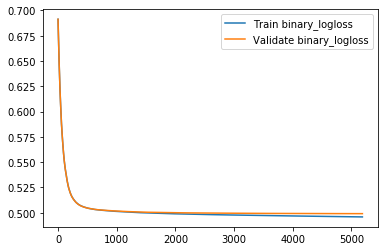

In [13]:
plt.plot([index for index in range(len(evaluation_results["Train"]["binary_logloss"]))],
         evaluation_results["Train"]["binary_logloss"], label="Train binary_logloss")
plt.plot([index for index in range(len(evaluation_results["Validate"]["binary_logloss"]))],
         evaluation_results["Validate"]["binary_logloss"], label="Validate binary_logloss")
plt.legend();

#printing the accuracy, precision, recall and the F1

#accuracy, at 76%, % of predicted results, predicted 76% of churned or not churned
#precision, of everyone labeled as churned, 78% actaully churned
#precision of everyone who actually churned, we labeled 80%
#F1 is useful for high class imbalance, our is balanced

In [14]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred),
      "\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%",
      "\nPrecision:", round(precision_score(y_test, y_pred) * 100, 2), "%",
      "\nRecall:", round(recall_score(y_test, y_pred) * 100, 2), "%",      
      "\nF1:", round(f1_score(y_test, y_pred) * 100, 2), "%")

Confusion Matrix:
 [[226271  96327]
 [ 89094 350733]] 
Accuracy: 75.68 % 
Precision: 78.45 % 
Recall: 79.74 % 
F1: 79.09 %
